## PyTorch Computer Vision

In [110]:
import torch 
import torch.nn as nn
import torchvision
from  torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.2.0+cu121
0.17.0+cu121


## Import Fashion MNIST

In [111]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

print(len(train_data), len(test_data))

60000 10000


In [112]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [113]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [114]:
image, label = train_data[0]
image.shape, label, train_data.targets # one color label

(torch.Size([1, 28, 28]), 9, tensor([9, 0, 0,  ..., 3, 0, 5]))

## Visualize Data

Image shape : torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

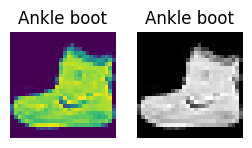

In [115]:
image, label = train_data[0]
print(f"Image shape : {image.shape}")
#plt.imshow(image) # error cause color channel first
fig = plt.figure(figsize=(3, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)
fig.add_subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)

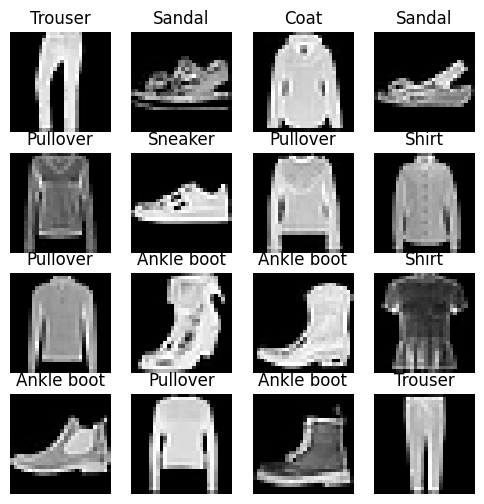

In [116]:
# more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(6,6))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

## Prepare DataLoader
(Converts dataset into python iterable) + (Batches/mini-Batches)
* Batches(usually 32) = more commputationally efficient(not all hardware can store all in mem in one go) + Gives NN more chances to update its gradients per epoch

In [117]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [118]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # Good cause dataset can have similar images nearby
test_dataloader = DataLoader(dataset = test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False) # For eval its good to not shuffle

In [119]:
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Number of Batches of Train DataLoader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Number of Batches of Test DataLoader : {len(test_dataloader)} batches of {test_dataloader.batch_size}") # gets rounded up if not divisible

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x000001D070D6A1D0>, <torch.utils.data.dataloader.DataLoader object at 0x000001D070423750>)
Number of Batches of Train DataLoader: 1875 batches of 32
Number of Batches of Test DataLoader : 313 batches of 32


In [120]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape # color channels first, varies prob to prob

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


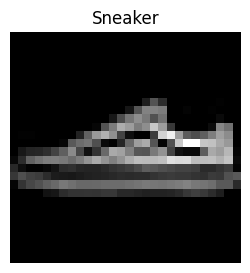

In [121]:
# Show a sample from batch
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Creating Baseline Model
Start simple and add complexity where necessary

In [122]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(x.shape)
out = flatten_model(x)
print(out.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [123]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [129]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names)).to('cpu')

dummy_X = torch.rand([1,1,28,28])
model_0(dummy_X)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)

### Own helper function script

In [130]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Already Exists, Skipping download")
else:
    print("Downloading Helper Functions script")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import accuracy_fn

Already Exists, Skipping download


### Time experiments
for performance(loss and acc) and speed(latency)

In [131]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device:torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [132]:
start_time = timer()
# Some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


1.4799999917158857e-05

## Train Loop on batches of data

In [135]:
# import tqdm for progress bar
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----")
    #Training
    train_loss = 0 # for per batch
    #Loop through training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate every batch and then div by num of batches for avg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # does once per batch not per epoch in batches

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader) # avg out across

    test_loss, test_acc = 0 , 0

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader: # no need to keep track of batches
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test) # accumulate
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}") 

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model_0.parameters()).device))  

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:07<00:15,  7.75s/it]


Train Loss: 0.5143 | Test Loss: 0.5295 | Test acc: 81.6993
Epoch: 1 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:15<00:07,  7.63s/it]


Train Loss: 0.5084 | Test Loss: 0.5334 | Test acc: 82.0687
Epoch: 2 
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:22<00:00,  7.40s/it]


Train Loss: 0.5019 | Test Loss: 0.5637 | Test acc: 80.3315
Train time on cpu: 22.201 seconds
